
# Spatial Transformer Network(STN)

## STN for distorted MNIST 

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time

%matplotlib inline

In [4]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'TITAN Xp'

In [5]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10


### MNIST Dataset random distortio

In [6]:
train_dataset = dset.MNIST("./data/mnist", train=True, 
                        transform = transforms.Compose([
                            transforms.Pad(26),
                            transforms.RandomAffine(degrees=45,
                            translate=(0.25,0.25), scale=(0.7,1.2)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,),(0.3081,))
                            ]),
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST("./data/mnist", train=False, 
                        transform = transforms.Compose([
                            transforms.Pad(26),
                            transforms.RandomAffine(degrees=45,
                            translate=(0.25,0.25), scale=(0.7,1.2)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,),(0.3081,))
                        ]),
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

/opt/conda/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [7]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 60000
Test dataset size: 10000


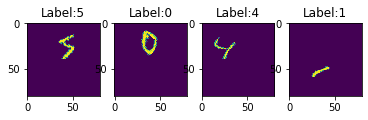

In [8]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [10]:
## Load Dataset
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

## STN CNN Module

In [11]:
# STN_CNN

class STN_CNN(nn.Module):
    def __init__(self):
        super(STN_CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=9, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.localization = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(20, 20, kernel_size=5, stride=1, padding=0),
            nn.ReLU()
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(23120,20),
            nn.ReLU(),
            nn.Linear(20,6)
        )
        self.AvgPool = nn.AvgPool2d(2, stride=2)

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):
        x_loc = self.localization(x)
        x_loc = x_loc.view(x_loc.size(0), 23120)
        theta = self.fc_loc(x_loc)
        theta = theta.view(-1,2,3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        x = self.AvgPool(x)
    
        return x

    def forward(self, x):
        x = self.stn(x)
        x = self.cnn(x)

        x = x.view(x.size(0), 1600)
        x = self.classifier(x)
        
        return x

In [12]:
model = STN_CNN()
print("STN_CNN's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STN_CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Train STN_CNN 

In [15]:
model.to(device0)
criterion = nn.CrossEntropyLoss()

best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        img = img.to(device0)
        label = label.to(device0)

        optimizer.zero_grad()
        outputs = model(img)

        loss = criterion(outputs, label)
        loss.backward()

        optimizer.step()
        
        if j % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
    #Test
    correct = 0
    total = 0
    model.eval()
    for images, labels in test_loader:

        images = images.to(device0)
        labels = labels.to(device0)
        
        outputs = model(images) 
        
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    
    print("")
    print('Test set Accuracy: {}'.format(accuracy))
    print("")
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)
    

Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:1.244727  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.703709  

Test set Accuracy: 77.94471153846153

////Epoch elapsed time: 11.634073972702026////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.608476  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.638240  

Test set Accuracy: 85.2363782051282

////Epoch elapsed time: 12.202444553375244////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.491818  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.574802  

Test set Accuracy: 87.26963141025641

////Epoch elapsed time: 11.671889066696167////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.416195  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.388119  

Test set Accuracy: 89.42307692307692

////Epoch elapsed time: 11.442041158676147////

Train Epoch: 4 [0/60000 (0%) / Learning rate:0.001]	Loss:0.353294  
Train Epoch: 4 [51200

## Visualizing Original & Transformed Output

In [19]:
model = STN_CNN()
checkpoint = torch.load('./best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [20]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])


Best accuracy of our model with ST module:  98.36738782051282


In [21]:
# Tensor image to array image

def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re


## Visualizing Transformed Images

In [22]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
    
        x_loc = self.model.localization(x)
        x_loc = x_loc.view(x_loc.size(0), 23120)
        theta = self.model.fc_loc(x_loc)
        theta = theta.view(-1,2,3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def visualize(self, img, i):
        
        # Original
        Orig_img = torch.utils.data.DataLoader(dataset=img, batch_size=16)
        Orig_img = next(iter(Orig_img))
        Orig_img = v_utils.make_grid(Orig_img, 4)

        # Make a grid from batch
        fig1 = plt.figure()
        fig1.add_subplot(1,2,1).set_title('Original images')
        plt.imshow(reprocess_image(Orig_img))
        
        # Transformed
        trans_img = self.forward_stn(img)
        trans_img = torch.utils.data.DataLoader(dataset=trans_img, batch_size=16)
        trans_img = next(iter(trans_img))
        trans_img = v_utils.make_grid(trans_img, 4)
        
        fig1.add_subplot(1,2,2).set_title('Transformed images')
        plt.imshow(reprocess_image(trans_img))
        plt.savefig('result' +str(i) +'.jpg')
        
        return img, trans_img


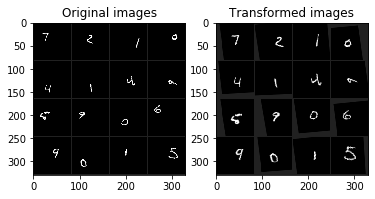

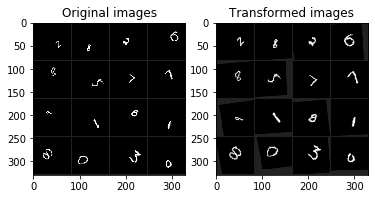

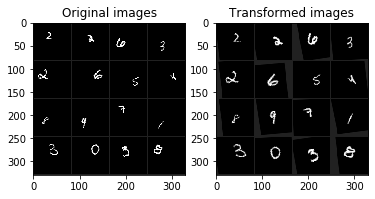

In [23]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img, i)
    
    if (i+1) == 3:
        break


## Comparing with model without STN

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(1, 32, kernel_size=9, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), 1600)
        x = self.classifier(x)
        
        return x


In [25]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [26]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [28]:
print('STEP 6: INSTANTIATE LOSS CLASS')

model_nostn.to(device0)
criterion = nn.CrossEntropyLoss()

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        img = img.to(device0)
        label = label.to(device0)

        optimizer.zero_grad()
        outputs = model_nostn(img)

        loss = criterion(outputs, label)
        loss.backward()

        optimizer.step()
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
    #Test

    correct = 0
    total = 0
    model_nostn.eval()
    for images, labels in test_loader:

        images = images.to(device0)
        labels = labels.to(device0)
        
        outputs =  model_nostn(images) 
        
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

    print("")
    print('Test set Accuracy: {}'.format(accuracy))
    print("")
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './best_model_CNN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

    

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:1.213161  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.788533  

Test set Accuracy: 76.6826923076923

////Epoch elapsed time: 11.77198839187622////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.684641  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.623381  

Test set Accuracy: 83.01282051282051

////Epoch elapsed time: 11.855977058410645////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.532706  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.458143  

Test set Accuracy: 84.01442307692308

////Epoch elapsed time: 11.390578985214233////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.615786  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.395949  

Test set Accuracy: 87.51001602564102

////Epoch elapsed time: 11.766795635223389////

Train Epoch: 4 [0/60000 (0%) / Lear

#### Best accuracy of the model without ST module


In [29]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  96.19391025641026


### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>